In [4]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , merge
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout, Flatten, Activation, Input, Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn

from keras.layers.merge import dot
from keras.models import Model

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#from google.colab import files
import io
import pandas as pd
import numpy as np

In [6]:
#data_to_load = files.upload()
df = pd.read_csv('ratings.csv')
df.head()

,Unnamed: 0,user_id,movie_id,rating,timestamp
0,0,196,242,3,881250949
1,1,186,302,3,891717742
2,2,22,377,1,878887116
3,3,244,51,2,880606923
4,4,166,346,1,886397596


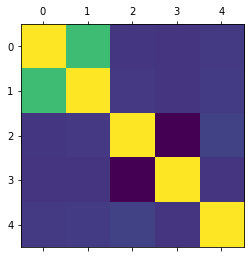

In [7]:
import matplotlib.pyplot as plt

plt.matshow(df.corr())
plt.show()

In [8]:
#Encoding the columns
df.user_id = df.user_id.astype('category').cat.codes.values
df.movie_id = df.movie_id.astype('category').cat.codes.values

#Creating the Utility Matrix
df.rating = df.rating.astype(float)

In [9]:
index = list(df['user_id'].unique())
columns = list(df['movie_id'].unique())
index = sorted(index)
columns = sorted(columns)

#Create Pivot Table from Utility Matrix
util_df = pd.pivot_table(data=df, values='rating', index='user_id', columns='movie_id')
util_df.head()

movie_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
util_df.fillna(0)

movie_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#Creating Training and Validation Sets

users = df.user_id.unique()
movies = df.movie_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

df['user_id'] = df['user_id'].apply(lambda x: userid2idx[x])
df['movie_id'] = df['movie_id'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]
print(train.shape , valid.shape)

(79965, 5) (20035, 5)


In [12]:
#Creating the Embeddings 

n_movies = len(df['movie_id'].unique())
n_users = len(df['user_id'].unique())
n_latent_factors = 64  # hyperparamter to deal with.

#User Embeddings
user_input = Input(shape=(1,),name='user_input',dtype='int64')
user_embedding = Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

#Movie Embeddings
movie_input = Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding = Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

In [13]:
sim = dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)
model = keras.models.Model([user_input, movie_input],sim)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        60352       user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 64)        107648      movie_input[0][0]                
____________________________________________________________________________________________

In [14]:
model.compile(optimizer=Adam(lr=1e-4),loss='mse')
batch_size=128
epochs=100
History = model.fit([train.user_id,train.movie_id],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.user_id,valid.movie_id],valid.rating),
                              verbose = 1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 79965 samples, validate on 20035 samples
Epoch 1/100
79965/79965 [==============================] - 3s 42us/step - loss: 13.7237 - val_loss: 13.7383
Epoch 2/100
79965/79965 [==============================] - 3s 40us/step - loss: 13.7122 - val_loss: 13.7275
Epoch 3/100
79965/79965 [==============================] - 3s 37us/step - loss: 13.6746 - val_loss: 13.6646
Epoch 4/100
79965/79965 [==============================] - 3s 39us/step - loss: 13.5227 - val_loss: 13.4019
Epoch 5/100
79965/79965 [==============================] - 3s 39us/step - loss: 13.0453 - val_loss: 12.6854
Epoch 6/100
79965/79965 [==============================] - 3s 43us/step - loss: 12.0297 - val_loss: 11.3914
Epoch 7/100
79965/79965 [==============================] - 3s 39us/step - loss: 10.4847 - val_loss: 9.6585
Epoch 8/100
79965/79965 [==============================] - 3s 39us/step - loss: 8.6382 - val_loss: 7.7712
Epoch 9/100
79965/79965 [==============================] - 3s 39us/step - loss: 6.7827 - 

79965/79965 [==============================] - 3s 44us/step - loss: 0.7241 - val_loss: 0.8629
Epoch 78/100
79965/79965 [==============================] - 4s 45us/step - loss: 0.7208 - val_loss: 0.8620
Epoch 79/100
79965/79965 [==============================] - 4s 46us/step - loss: 0.7175 - val_loss: 0.8610
Epoch 80/100
79965/79965 [==============================] - 4s 47us/step - loss: 0.7142 - val_loss: 0.8602
Epoch 81/100
79965/79965 [==============================] - 4s 47us/step - loss: 0.7109 - val_loss: 0.8592
Epoch 82/100
79965/79965 [==============================] - 4s 52us/step - loss: 0.7075 - val_loss: 0.8581
Epoch 83/100
79965/79965 [==============================] - 4s 47us/step - loss: 0.7040 - val_loss: 0.8572
Epoch 84/100
79965/79965 [==============================] - 4s 47us/step - loss: 0.7007 - val_loss: 0.8565
Epoch 85/100
79965/79965 [==============================] - 4s 48us/step - loss: 0.6972 - val_loss: 0.8555
Epoch 86/100
79965/79965 [========================

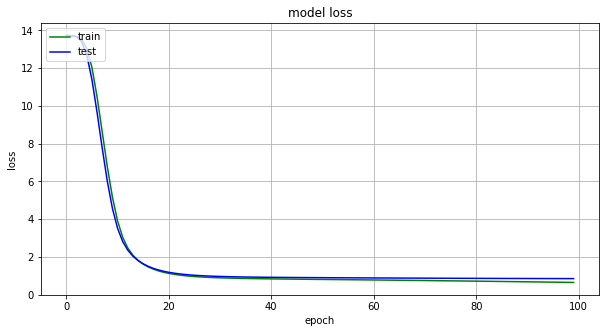

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [16]:
prediction = model.predict([valid.user_id, valid.movie_id])
array_pred = prediction.reshape(-1,)
predicts = array_pred*2
predicts = predicts.astype(int)/2
accuracy_score(valid.rating.astype(str), predicts.astype(str))

0.19775393062141253

In [33]:
#valid.movie_id
prediction

array([[3.6199355],
       [3.0434856],
       [3.3076918],
       ...,
       [3.7853508],
       [2.6215875],
       [4.18202  ]], dtype=float32)

### I believe that the deep learning method is better than the ml method for recommendations for several reasons. It takes less effort to implement a deep learning algorithm for a recommendation system since it can figure out the features more efficiently. Deep learning models can also model non-linear interactions in the data with non-linear activations. The only issue with deep learning model in this aspect is that I could not figure out, even after many hours of research, how to convert the prediction array into human readable movie titles. It is a very tricky process.